In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git
! git clone https://github.com/ebanalyse/ebnerd-benchmark.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 362 (delta 21), reused 28 (delta 20), pack-reused 325
Receiving objects: 100% (362/362), 17.90 MiB | 48.75 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Cloning into 'ebnerd-benchmark'...
remote: Enumerating objects: 454, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 454 (delta 11), reused 20 (delta 8), pack-reused 412
Receiving objects: 100% (454/454), 15.24 MiB | 52.73 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature

from catboost import CatBoostClassifier

# Memory Utils

In [4]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.4029


In [5]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [6]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.6593


# Articles Preprocessing

In [7]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')) 
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 64.11 MB
Memory usage after optimization is: 63.96 MB
Decreased by 0.2%

RAM memory GB usage = 0.6679


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116


In [8]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['EVENT', 'PROD', 'PER', 'LOC', 'ORG', 'MISC']

In [9]:
unique_categories = articles.select('category')['category'].unique().to_list()
unique_categories = [c for c in unique_categories if c is not None]
len(unique_categories)

25

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [10]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 0.6855


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]"


In [12]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Precalculating similarities

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer()
# topics_sparse = count_vectorizer.fit_transform(
#     articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
# )
# topics_sparse

In [14]:
# len(count_vectorizer.get_feature_names_out())

In [15]:
# %%time

# topics_sparse.dot(topics_sparse.T)

In [16]:
# %%time


# intersections = topics_sparse.dot(topics_sparse.T.tocsc())
# row_sums = intersections.diagonal()
# unions = row_sums[:,None] + row_sums - intersections
# similarities = intersections / unions

# gc.collect()
# PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
# articles.head(2)

# History preprocessing

In [17]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [18]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:09,  1.61it/s]                        



RAM memory GB usage = 0.805
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 11.4 s, sys: 903 ms, total: 12.3 s
Wall time: 10.3 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,EVENTPct,PRODPct,PERPct,LOCPct,ORGPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,3,16,"[0.016041, 0.062928, … 0.178427]",0.202797,0.237762,0.874126,0.804196,0.888112,0.223776
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.087121,0.318182,0.787879,0.776515,0.852273,0.117424


In [19]:
history_train.shape

(15143, 27)

# Creating Training Dataframe

In [20]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, 
                                with_replacement=True, seed=123) \
    .pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()


RAM memory GB usage = 1.016
Memory usage of dataframe is 67.71 MB
Memory usage after optimization is: 57.04 MB
Decreased by 15.8%

RAM memory GB usage = 0.9976
CPU times: user 31.9 s, sys: 1.13 s, total: 33 s
Wall time: 13.4 s


impression_id,article,impression_time,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,session_id,trendiness_publications_score,weekday,hour,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present
u32,i32,datetime[μs],i8,i8,f32,f32,u32,bool,i8,i8,bool,u32,i16,i8,i8,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool
149474,9778728,2023-05-24 07:47:53,0,2,13.0,null,139836,false,2,null,false,759,487,3,7,false,2023-05-24 07:26:05,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,true,false,true,false
149474,9778657,2023-05-24 07:47:53,1,2,13.0,null,139836,false,2,null,false,759,138,3,7,false,2023-05-24 05:53:58,118,0.8347,"""Neutral""",2,6,31,336,0,1,false,false,true,true,true,true
150528,9778682,2023-05-24 07:33:25,0,2,25.0,null,143471,false,2,null,false,1240,218,3,7,false,2023-05-24 06:32:42,498,0.9546,"""Negative""",1,5,20,267,0,1,true,true,true,false,true,false
153068,9778682,2023-05-24 07:09:04,0,1,78.0,100.0,151570,false,2,null,false,1976,218,3,7,false,2023-05-24 06:32:42,498,0.9546,"""Negative""",1,5,20,267,0,0,true,true,true,false,true,false
153071,9775990,2023-05-24 07:11:08,0,1,125.0,100.0,151570,false,2,null,false,1976,439,3,7,false,2023-05-22 11:48:18,142,0.5539,"""Neutral""",1,4,20,382,1,43,true,false,true,true,true,true


In [21]:
train_ds.shape

(699537, 33)

## Session Features

In [22]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [23]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])
history_train = history_train.drop(['impression_time_fixed'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'category']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
        pl.col('article_ids_clicked').count().alias('session_nclicks'),
        # pl.col('category').alias('all_categories'),
        pl.col('category').mode().alias('most_freq_category'),
    ).sort(['user_id', 'session_time']).with_columns(
        pl.col('most_freq_category').list.first(),
    ).with_columns(
        pl.col(['session_time', 'session_nclicks', 'session_duration', 'most_freq_category']) \
            .shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_nclicks', 'last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_nclicks', 'last_most_freq_category',
              'last_session_duration', 'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 1.022
CPU times: user 1.59 s, sys: 91.2 ms, total: 1.68 s
Wall time: 1.12 s


session_id,last_session_time,last_session_nclicks,last_most_freq_category,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],u32,i16,i64,list[i32],f64
1969198,2023-05-16 19:48:21,0,null,0,[9759717],0.0
1969199,2023-05-24 18:58:45,1,140,0,"[9762352, 9777321, … 9779748]",0.0


In [24]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    (pl.col('category') == pl.col('last_most_freq_category')).fill_null(False).alias('is_last_session_most_seen_category'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time', 'last_most_freq_category'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 1.091


impression_id,article,impression_time,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_publications_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category
u32,i32,datetime[μs],i8,i8,f32,f32,u32,bool,i8,i8,bool,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool
149474,9778728,2023-05-24 07:47:53,0,2,13.0,null,139836,false,2,null,false,487,3,7,false,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,true,false,true,false,3,1,1.0,88,false,false,false
149474,9778657,2023-05-24 07:47:53,1,2,13.0,null,139836,false,2,null,false,138,3,7,false,118,0.8347,"""Neutral""",2,6,31,336,0,1,false,false,true,true,true,true,3,1,1.0,88,false,false,true


In [25]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.292472,0.088208


In [26]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [27]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 67.96 MB
Memory usage after optimization is: 53.95 MB
Decreased by 20.6%

RAM memory GB usage = 1.08
CPU times: user 433 ms, sys: 18.3 ms, total: 451 ms
Wall time: 380 ms


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_publications_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,u32,i8,f32,i16,bool,bool,bool,f32
149474,9778728,0,2,13.0,null,139836,false,2,null,false,487,3,7,false,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,true,false,true,false,3,1,1.0,88,false,false,false,0.246377
149474,9778657,1,2,13.0,null,139836,false,2,null,false,138,3,7,false,118,0.8347,"""Neutral""",2,6,31,336,0,1,false,false,true,true,true,true,3,1,1.0,88,false,false,true,0.275362


# Adding history features

In [28]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the number of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


def batch_cosine_similarity(df, col1, col2, target_col):
    X = np.array(df[col1].to_list())
    Y = np.array(df[col2].to_list())
    norm = np.linalg.norm(X, 2, axis=1) * np.linalg.norm(Y, 2, axis=1)
    cosine = np.where(norm > 0, np.sum(X * Y, axis=1) / norm, 0)
    return df.with_columns(pl.Series(cosine).alias(target_col))


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf']), left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups']), left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .with_columns(
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
        ).join(history_train.drop(['article_id_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

70it [05:35,  4.79s/it]



RAM memory GB usage = 1.559


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_publications_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,MeanCommonEntities,MaxCommonEntities,mean_JS,min_JS,max_JS,std_JS,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,EVENTPct,PRODPct,PERPct,LOCPct,ORGPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,u32,i8,f32,i16,bool,bool,bool,f32,f64,u32,f64,f64,f64,f64,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u32,f64
153071,9775990,0,1,125.0,100.0,151570,false,2,null,false,439,3,7,false,142,0.5539,"""Neutral""",1,4,20,382,1,43,true,false,true,true,true,true,2,2,3.333333,11,true,false,false,0.246377,2.996219,5,0.168996,0.0,1.0,0.245702,1058,16.0,1548.0,42896.0,100.0,100.0,0.259924,0.190926,0.549149,0.104915,0.111531,0.465974,0.031191,118,5,5,0.241021,0.335539,0.883743,0.756144,0.91966,0.195652,0.509346,false,10,0.991493
155587,9778375,1,1,50.0,100.0,161621,false,2,null,false,204,3,7,false,118,0.9979,"""Negative""",0,10,18,296,0,9,false,false,false,true,true,false,1,0,5.818182,19,false,false,false,0.275362,1.629723,2,0.115991,0.0,0.666667,0.149668,397,30.0,1256.0,24994.0,100.0,100.0,0.219144,0.088161,0.692695,0.088161,0.050378,0.617128,0.032746,118,3,10,0.120907,0.27204,0.816121,0.70529,0.924433,0.206549,0.385166,true,9,0.979849


In [29]:
# .pipe(batch_cosine_similarity, col1='topics_idf', col2='topics_flatten_tf_idf', target_col='topics_cosine') \

# Training

In [30]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'is_last_session_most_seen_category']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [31]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.808


In [32]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.318943
0:	learn: 0.6264911	total: 1.14s	remaining: 9m 27s
25:	learn: 0.5462177	total: 20s	remaining: 6m 4s
50:	learn: 0.5368338	total: 38.4s	remaining: 5m 38s
75:	learn: 0.5299335	total: 57.4s	remaining: 5m 20s
100:	learn: 0.5255382	total: 1m 16s	remaining: 5m
125:	learn: 0.5222071	total: 1m 35s	remaining: 4m 42s
150:	learn: 0.5193959	total: 1m 54s	remaining: 4m 23s
175:	learn: 0.5167835	total: 2m 12s	remaining: 4m 4s
200:	learn: 0.5146069	total: 2m 32s	remaining: 3m 46s
225:	learn: 0.5127470	total: 2m 51s	remaining: 3m 28s
250:	learn: 0.5106108	total: 3m 11s	remaining: 3m 9s
275:	learn: 0.5092467	total: 3m 30s	remaining: 2m 50s
300:	learn: 0.5079554	total: 3m 49s	remaining: 2m 31s
325:	learn: 0.5066056	total: 4m 8s	remaining: 2m 12s
350:	learn: 0.5052157	total: 4m 27s	remaining: 1m 53s
375:	learn: 0.5040320	total: 4m 47s	remaining: 1m 34s
400:	learn: 0.5028103	total: 5m 6s	remaining: 1m 15s
425:	learn: 0.5015002	total: 5m 26s	remaining: 56.8s
450:	learn: 0.50032

In [33]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 4.93 s, sys: 36 ms, total: 4.97 s
Wall time: 4.86 s


Text(0.5, 1.0, 'Catboost Feature Importances')

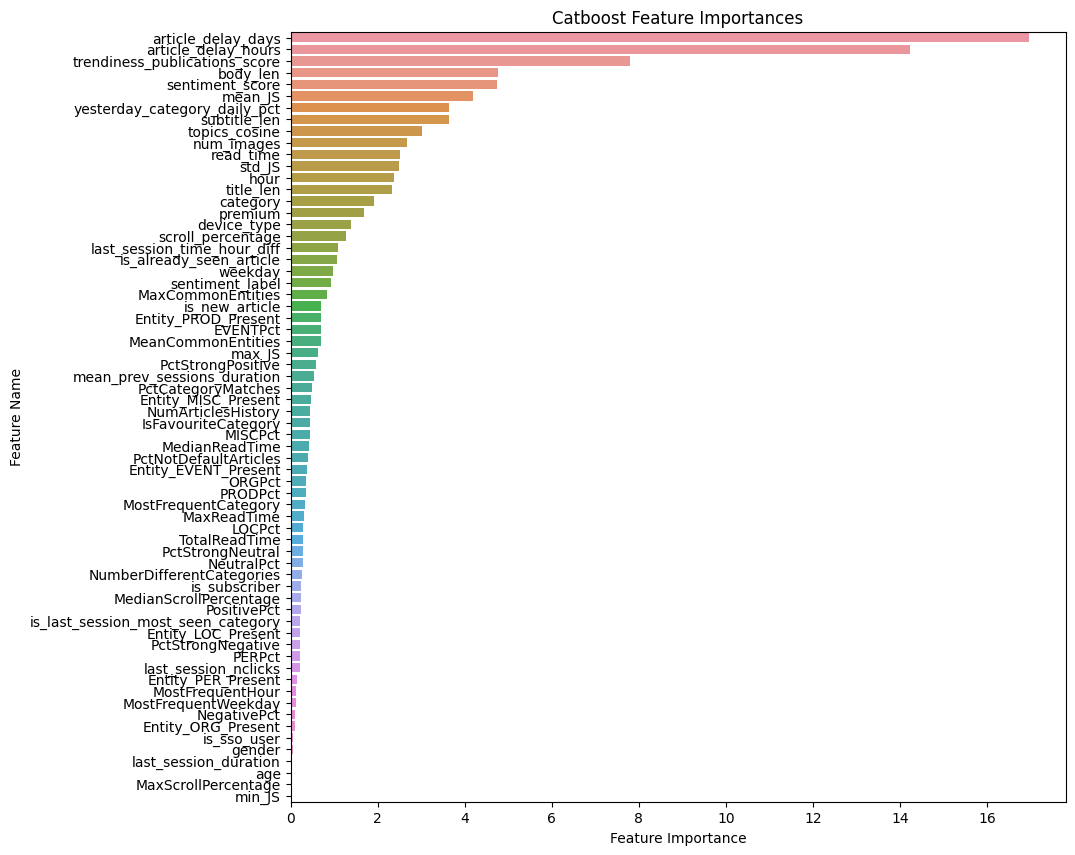

In [34]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [35]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 3.228


# Model Evaluation

In [36]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:09,  1.72it/s]                        



RAM memory GB usage = 2.859
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 10.8 s, sys: 886 ms, total: 11.7 s
Wall time: 9.7 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,EVENTPct,PRODPct,PERPct,LOCPct,ORGPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.3,0.213333,0.893333,0.846667,0.913333,0.266667
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,1,7,"[0.0, 0.048524, … 0.217846]",0.114035,0.254386,0.807018,0.815789,0.947368,0.192982


In [37]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])
history_val = history_val.drop(['impression_time_fixed'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'category']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
        pl.col('article_ids_clicked').count().alias('session_nclicks'),
        # pl.col('category').alias('all_categories'),
        pl.col('category').mode().alias('most_freq_category'),
    ).sort(['user_id', 'session_time']).with_columns(
        pl.col('most_freq_category').list.first(),
    ).with_columns(
        pl.col(['session_time', 'session_nclicks', 'session_duration', 'most_freq_category']) \
            .shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_nclicks', 'last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_nclicks', 'last_most_freq_category',
              'last_session_duration', 'all_seen_articles', 'mean_prev_sessions_duration'])

In [38]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
        (pl.col('category') == pl.col('last_most_freq_category')).fill_null(False).alias('is_last_session_most_seen_category'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time', 'last_most_freq_category']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()


RAM memory GB usage = 4.491
Memory usage of dataframe is 329.26 MB
Memory usage after optimization is: 225.90 MB
Decreased by 31.4%

RAM memory GB usage = 4.39
CPU times: user 1min 49s, sys: 4.71 s, total: 1min 54s
Wall time: 34.3 s


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_publications_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,u32,i8,f32,i16,bool,bool,bool,f32
96798,9782884,0,2,46.0,null,22548,false,2,null,false,90,7,4,false,512,0.9475,"""Negative""",7,5,24,458,0,7,false,true,true,true,true,false,5,11,3.0,0,true,true,false,0.008929
96798,9783405,0,2,46.0,null,22548,false,2,null,false,250,7,4,true,565,0.8513,"""Neutral""",1,6,35,310,0,8,false,true,true,false,false,false,5,11,3.0,0,true,false,false,0.008929
96798,9784444,0,2,46.0,null,22548,false,2,null,false,124,7,4,false,118,0.5828,"""Negative""",1,4,21,247,0,11,false,false,true,true,true,true,5,11,3.0,0,true,false,false,0.276786
96798,9782057,0,2,46.0,null,22548,false,2,null,false,511,7,4,false,142,0.8738,"""Neutral""",2,6,16,304,1,42,false,false,true,true,true,true,5,11,3.0,0,true,false,true,0.357143
96798,9784583,0,2,46.0,null,22548,false,2,null,false,72,7,4,false,118,0.7946,"""Negative""",1,4,17,186,0,9,false,true,true,true,true,true,5,11,3.0,0,true,false,false,0.276786


In [39]:
val_ds.shape

(2928942, 38)

In [40]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf']), left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups']), left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .with_columns(
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .group_by(['impression_id', 'article']).agg(
            pl.col(prev_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
        ).join(history_val.drop(['article_id_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [21:35,  4.42s/it]


Memory usage of dataframe is 612.07 MB
Memory usage after optimization is: 536.65 MB
Decreased by 12.3%

RAM memory GB usage = 4.941


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_publications_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_PROD_Present,Entity_PER_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,MeanCommonEntities,MaxCommonEntities,mean_JS,min_JS,max_JS,std_JS,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,EVENTPct,PRODPct,PERPct,LOCPct,ORGPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,u32,i8,f32,i16,bool,bool,bool,f32,f32,u32,f32,f32,f32,f32,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32
96798,9783405,0,2,46.0,null,22548,false,2,null,false,250,7,4,true,565,0.8513,"""Neutral""",1,6,35,310,0,8,false,true,true,false,false,false,5,11,3.0,0,true,false,false,0.008929,1.138462,2,0.095768,0.0,0.833333,0.158607,130,16.0,650.0,4581.0,37.0,100.0,0.253846,0.153846,0.592308,0.115385,0.092308,0.507692,0.046154,118,1,9,0.238462,0.3,0.838462,0.738462,0.930769,0.184615,0.294572,false,7,0.946154
96798,9784444,0,2,46.0,null,22548,false,2,null,false,124,7,4,false,118,0.5828,"""Negative""",1,4,21,247,0,11,false,false,true,true,true,true,5,11,3.0,0,true,false,false,0.276786,2.692308,4,0.067924,0.0,1.0,0.180335,130,16.0,650.0,4581.0,37.0,100.0,0.253846,0.153846,0.592308,0.115385,0.092308,0.507692,0.046154,118,1,9,0.238462,0.3,0.838462,0.738462,0.930769,0.184615,0.24379,true,7,0.953846
96801,9781785,0,2,14.0,null,22548,false,2,null,false,511,7,4,false,142,0.9793,"""Positive""",2,8,23,292,2,55,true,false,true,true,true,false,5,11,3.0,0,true,true,true,0.357143,2.746154,4,0.188312,0.0,1.0,0.272036,130,16.0,650.0,4581.0,37.0,100.0,0.253846,0.153846,0.592308,0.115385,0.092308,0.507692,0.046154,118,1,9,0.238462,0.3,0.838462,0.738462,0.930769,0.184615,0.589555,false,7,0.953846
96810,9782108,0,2,23.0,null,22548,false,2,null,false,389,7,4,false,142,0.9807,"""Negative""",1,5,19,190,1,43,true,false,true,true,true,false,1,0,3.5,12,true,false,true,0.357143,2.746154,4,0.159201,0.0,1.0,0.288552,130,16.0,650.0,4581.0,37.0,100.0,0.253846,0.153846,0.592308,0.115385,0.092308,0.507692,0.046154,118,1,9,0.238462,0.3,0.838462,0.738462,0.930769,0.184615,0.52031,false,7,0.953846
96818,9784702,0,2,6.0,null,22548,false,2,null,false,389,7,4,false,142,0.7025,"""Positive""",1,7,19,208,0,7,true,false,true,true,true,false,1,0,3.5,12,false,false,true,0.357143,2.746154,4,0.159201,0.0,1.0,0.288552,130,16.0,650.0,4581.0,37.0,100.0,0.253846,0.153846,0.592308,0.115385,0.092308,0.507692,0.046154,118,1,9,0.238462,0.3,0.838462,0.738462,0.930769,0.184615,0.52031,false,7,0.953846


In [41]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [42]:
val_ds.shape

(2928942, 70)

In [43]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
96798,0,0.188266
96798,0,0.495427
96801,0,0.092108
96810,0,0.189357
96818,0,0.620009
…,…,…
579250183,0,0.053085
579250699,0,0.146555
579251519,0,0.247246


In [44]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
527138489,"[0, 0, … 0]","[0.400086, 0.474293, … 0.341274]"
82531373,"[0, 0, … 1]","[0.753734, 0.49087, … 0.307237]"
240469716,"[0, 0, … 0]","[0.027933, 0.003529, … 0.003043]"
330550618,"[0, 0, … 0]","[0.657945, 0.252435, … 0.164302]"
557792086,"[0, 1, … 0]","[0.040443, 0.62349, … 0.028108]"
…,…,…
502636781,"[1, 0, … 0]","[0.477657, 0.014227, … 0.007647]"
54857036,"[0, 0, … 0]","[0.255663, 0.035424, … 0.402124]"
340393416,"[0, 0, … 0]","[0.552632, 0.40017, … 0.09836]"


In [45]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 4min 16s, sys: 262 ms, total: 4min 16s
Wall time: 4min 16s


<MetricEvaluator class>: 
 {
    "auc": 0.7188048212180166,
    "mrr": 0.4929288381662725,
    "ndcg@5": 0.5509065411390673,
    "ndcg@10": 0.5958557275874775
}